In [1]:
%cd ../RADOM

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from plotting import *

/home/mffang/workspace/Poisson-regression/RADOM


In [2]:
import scanpy as sc
import scvelo as scv
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def select_genes(U,S,gene_names,mean_min=0.1,var_min=1):
    gene_mask = (np.mean(S,axis=0)>0) & (np.mean(U,axis=0)>0) & (np.var(S,axis=0)>0) & (np.var(U,axis=0)>0)
    s = S[:,gene_mask]
    u = U[:,gene_mask]
    gene_names = gene_names[gene_mask]
    cov = np.cov(u,s,rowvar=False)
    s_mean = np.mean(s,axis=0)
    u_mean = np.mean(u,axis=0)
    X_mean = np.append(u_mean,s_mean)
    p = s.shape[1]
    rho = cov/X_mean[:,None]/X_mean[None,:]
    rho_s = rho[p:,p:]
    rho_u = rho[:p,:p]
    rho_us = rho[:p,p:]
    s = (np.sum(rho_us)-np.sum(np.diag(rho_us)))/(p-1)/p
    genes_mask = (s_mean>mean_min) & (u_mean>mean_min) & (np.abs(np.diag(rho_us)-s)>var_min)
    return gene_names[genes_mask]

In [4]:
adata = sc.read('../data/sperm_pb.loom')
adata.var_names_make_unique
adata

AnnData object with n_obs × n_vars = 3000 × 18255
    layers: 'matrix', 'spliced', 'unspliced'

In [5]:
U = adata.layers['unspliced'].toarray()
S = adata.layers['spliced'].toarray()

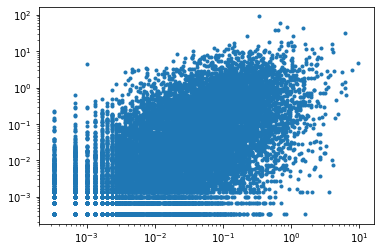

In [6]:
plt.loglog(U.mean(axis=0),S.mean(axis=0),'.');

In [7]:
sc.pp.pca(adata)

In [15]:
x = data.obsm['X_pca']

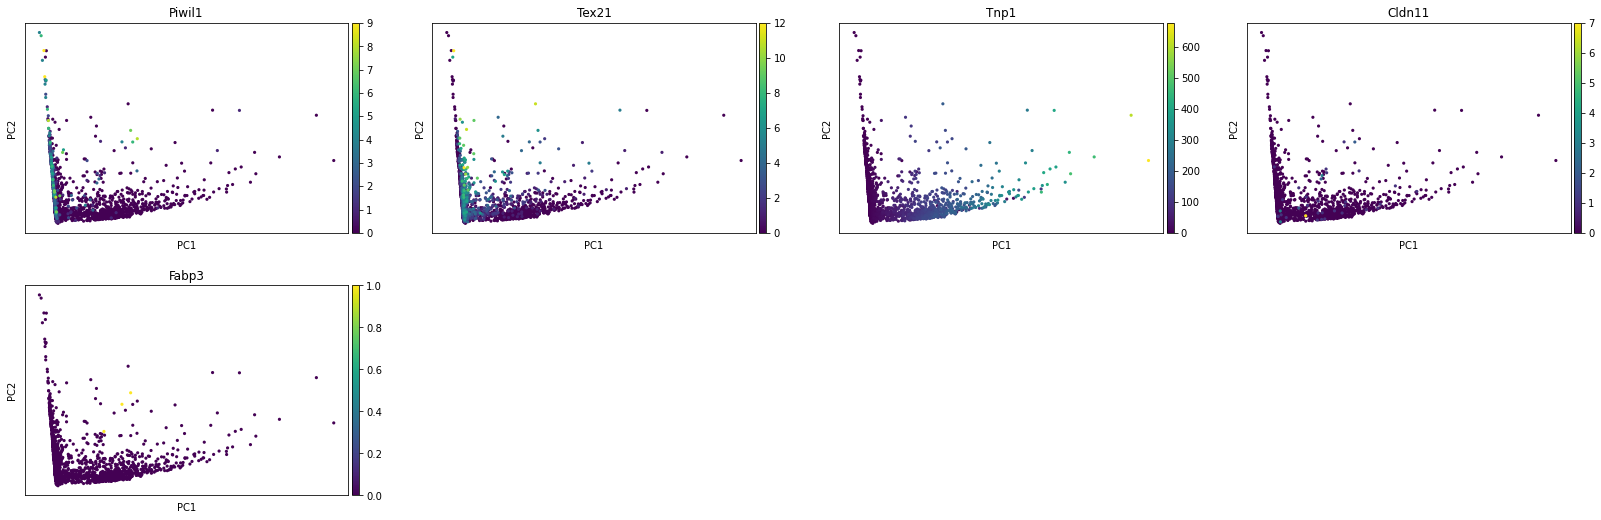

In [8]:
sc.pl.pca(adata,color=['Piwil1', 'Tex21','Tnp1','Cldn11', 'Fabp3'])

In [10]:
data = adata

In [11]:
sc.pp.highly_variable_genes(data,n_top_genes=100,flavor="seurat_v3")
gene_mask = (data.var_names.isin(['Piwil1', 'Tex21','Tnp1'])) | (data.var['highly_variable']) & (data.layers["unspliced"].toarray().mean(axis=0) > 0.01) & (data.layers["spliced"].toarray().mean(axis=0) > 0.01)
fitted_genes = data.var_names[gene_mask]
print(np.sort(fitted_genes))

['1700001P01Rik' '1700015G11Rik' '1700016C15Rik' '1700016H13Rik'
 '1700042G07Rik' '2200002J24Rik' '4933411K16Rik' 'Actg1' 'Actrt3'
 'Ankrd54' 'Atxn7l3b' 'BC049730' 'Banf2' 'Cabs1' 'Ccdc185' 'Ccin' 'Cd320'
 'Cdc42ep3' 'Cks2' 'Cst13' 'Cstl1' 'Cypt12' 'Cypt4' 'Ddt' 'Diablo'
 'Dnajb8' 'Dusp13' 'Elp5' 'Fam209' 'Fam71b' 'Gmcl1' 'H2afz' 'Hmgb2'
 'Hmgb4' 'Mesdc2' 'Mllt10' 'Mrps36' 'Mtl5' 'Nubp2' 'Pabpc6' 'Paqr5'
 'Pex5l' 'Piwil1' 'Pou5f2' 'Prm1' 'Prm2' 'Prss37' 'Prss52' 'Ptma' 'Rassf1'
 'Rnf166' 'Rpl14' 'Rps27a' 'Rsph1' 'Rsph3a' 'Scp2d1' 'Spaca9' 'Ssna1'
 'Sycp1' 'Tex101' 'Tex21' 'Tex29' 'Tex37' 'Them6' 'Tmem144' 'Tnp1' 'Tnp2'
 'Trp53tg5' 'Zmynd10']


marker genes: Piwil1 (spermatocytes), Tex21 (round spermatids), Tnp1 (elongating spermatids), Cldn11 (Sertoli cells) and Fabp3 (Leydig cells).

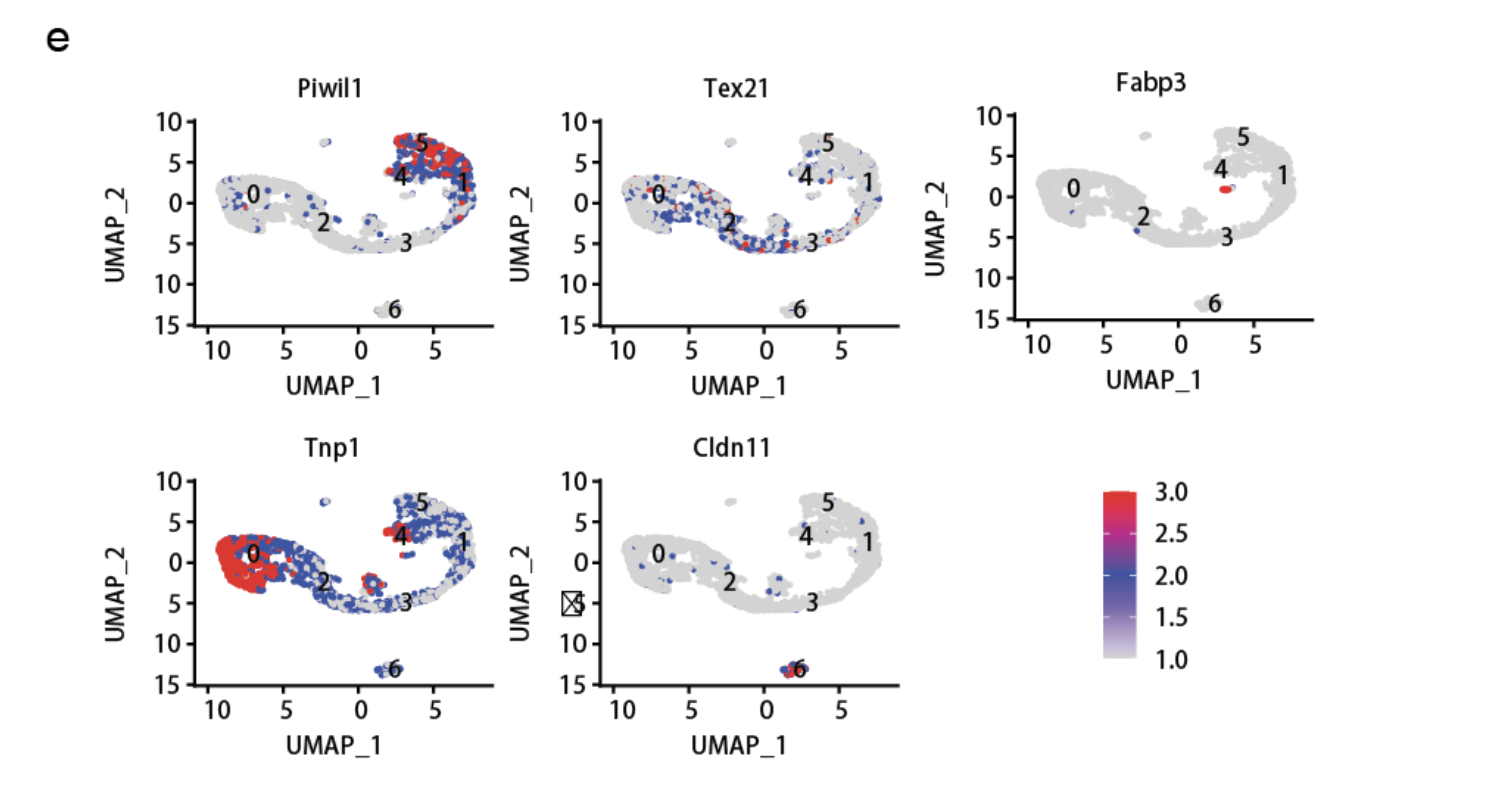

In [12]:
marker_genes = ['Piwil1', 'Tex21','Tnp1','Cldn11', 'Fabp3']
plot_idx = np.arange(len(fitted_genes))[fitted_genes.isin(marker_genes)]
fitted_genes[plot_idx]

Index(['Tnp1', 'Piwil1', 'Tex21'], dtype='object')

In [13]:
X = np.zeros((data.X.shape[0],np.sum(gene_mask),2))
X[:,:,0] = data.layers["unspliced"].toarray()[:,gene_mask]
X[:,:,1] = data.layers["spliced"].toarray()[:,gene_mask]
X.shape

(3000, 69, 2)

In [14]:
topo = np.array([[0,1]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,n_init=10,epoch=100,parallel=True,n_threads=4)

run method fit_multi_init
trial 1


100%|██████████| 100/100 [00:34<00:00,  2.89it/s]

trial 2



 68%|██████▊   | 68/100 [00:24<00:11,  2.82it/s]

trial 3



 70%|███████   | 70/100 [00:30<00:13,  2.30it/s]

trial 4



100%|██████████| 100/100 [00:46<00:00,  2.17it/s]

trial 5



 57%|█████▋    | 57/100 [00:22<00:16,  2.54it/s]

trial 6



 26%|██▌       | 26/100 [00:10<00:29,  2.49it/s]

trial 7



 37%|███▋      | 37/100 [00:14<00:24,  2.53it/s]

trial 8



 40%|████      | 40/100 [00:15<00:23,  2.56it/s]

trial 9



100%|██████████| 100/100 [00:36<00:00,  2.73it/s]

trial 10



100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


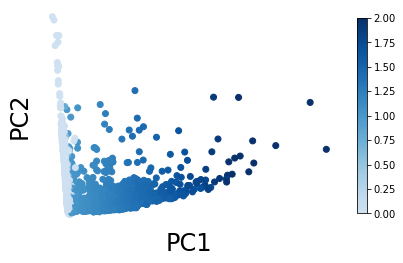

In [17]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

<AxesSubplot:>

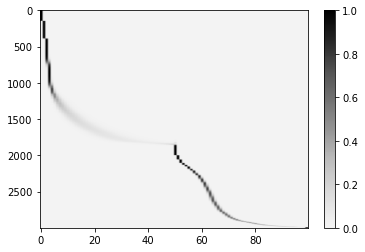

In [18]:
plot_t(traj.Q,order_cells=True)

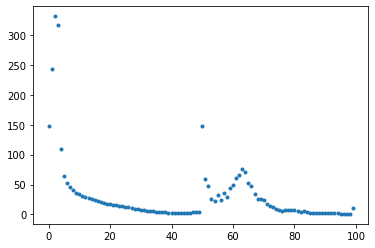

In [19]:
plt.plot(traj.Q.sum(axis=(0,1)),'.')

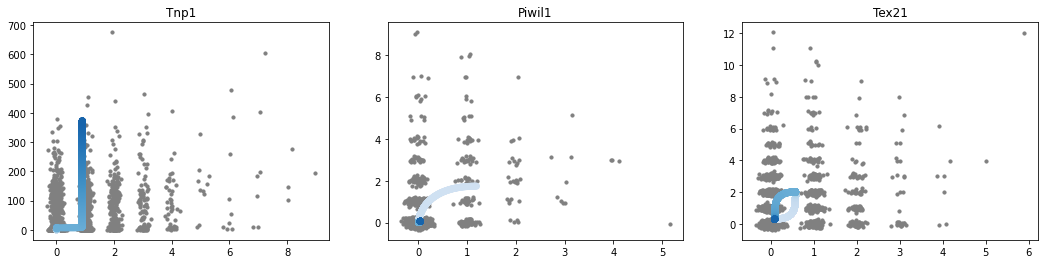

In [20]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes)

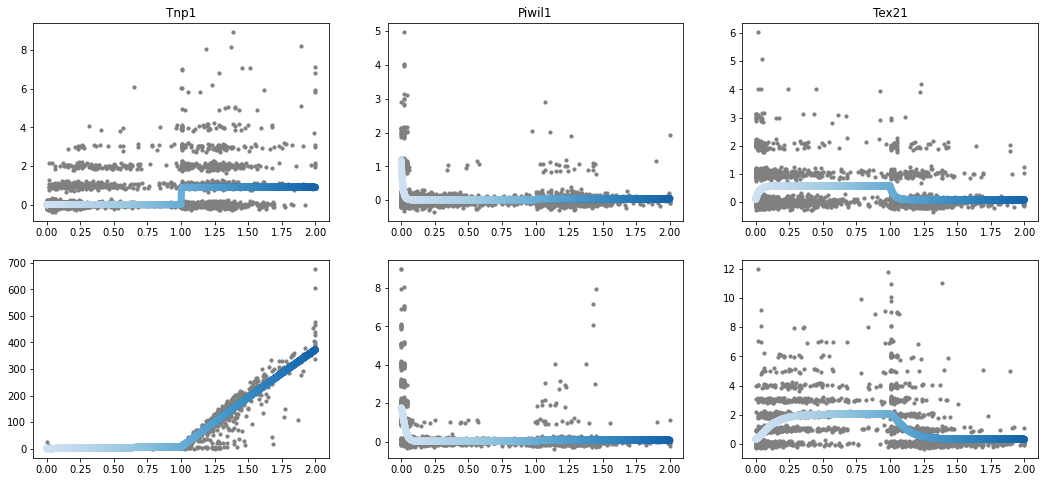

In [21]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes)

In [22]:
traj.theta[plot_idx,:]

array([[1.54550193e-02, 8.98638356e-01, 9.88785867e-05, 4.25269465e+02,
        8.09292333e-02],
       [1.02784494e-02, 4.43164344e-02, 1.19485528e+00, 8.38142072e+01,
        5.73878829e+01],
       [5.70453836e-01, 8.70312764e-02, 9.20540581e-02, 3.57800118e+01,
        1.00792180e+01]])